In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Stochastic Environment

In [17]:
prices = np.linspace(0, 1, 100)
n_customers = 100

conversion_probability = lambda p: 1-p
cost = 0.5
min_price, max_price = 0, 1
reward_function = lambda price, n_sales: (price-cost)*n_sales

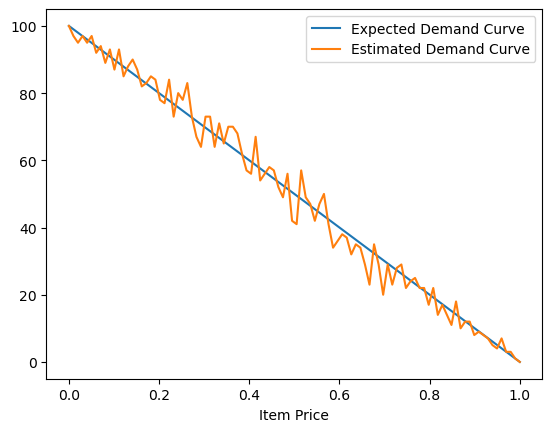

In [18]:
expected_demand_curve = n_customers*conversion_probability(prices)
estimated_demand_curve = np.random.binomial(n_customers, conversion_probability(prices))

plt.figure()
plt.plot(prices, expected_demand_curve, label='Expected Demand Curve')
plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show();

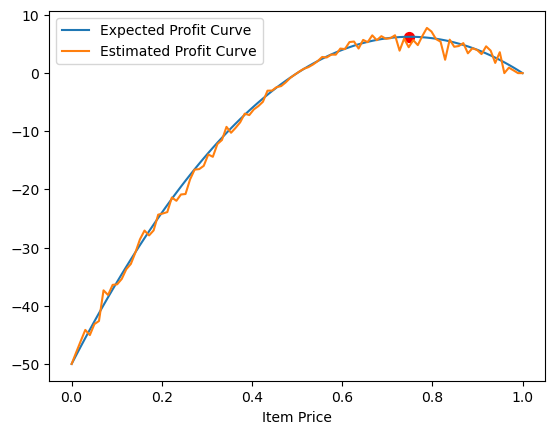

In [19]:
expected_profit_curve = n_customers*conversion_probability(prices)*(prices-cost)
estimated_profit_curve = np.random.binomial(n_customers, conversion_probability(prices))*(prices-cost)

best_price_index = np.argmax(expected_profit_curve)
best_price = prices[best_price_index]

plt.figure()
plt.plot(prices, expected_profit_curve, label='Expected Profit Curve')
plt.plot(prices, estimated_profit_curve, label='Estimated Profit Curve')
plt.scatter(best_price, expected_profit_curve[best_price_index], color='red', s=50)
plt.xlabel('Item Price')
plt.legend()
plt.show();

# Pricing in Stochastical Environment

In [20]:
class Environment:
    def __init__(self):
        pass

    def round(self, a_t):
        pass

In [21]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t)) # number of sells
        r_t = (p_t - self.cost)*d_t # reward
        return d_t, r_t

In [22]:
env = PricingEnvironment(conversion_probability=conversion_probability, cost=0.3)
env.round(0.8, 100)

(18, 9.0)

In [23]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [24]:
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        # TDOD set parameters??
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

In [25]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

T = 500
agent = GPUCBAgent(T)
np.random.seed(2)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    d_t, r_t = env.round(p_t, n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

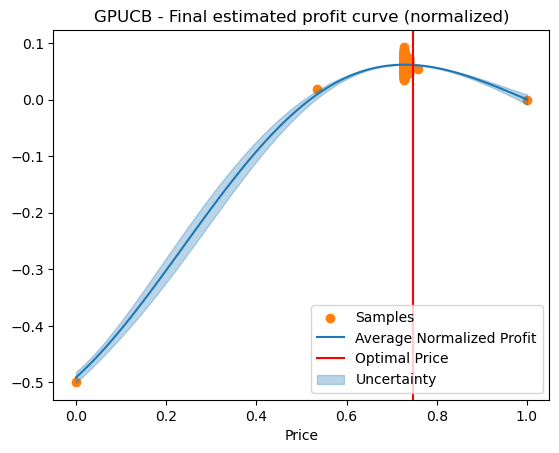

In [26]:
prices = rescale(agent.action_hist, min_price, max_price)
profits = agent.reward_hist

gp = RBFGaussianProcess(scale=2)
gp.fit(prices, profits)
mu, sigma = gp.predict(np.linspace(0,1,100))
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(0,1,100), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(0,1,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

C:\Users\Amelie\AppData\Local\Temp\ipykernel_21320\474933825.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(cumulative_regret/times, label='Cumulative Regret over time')


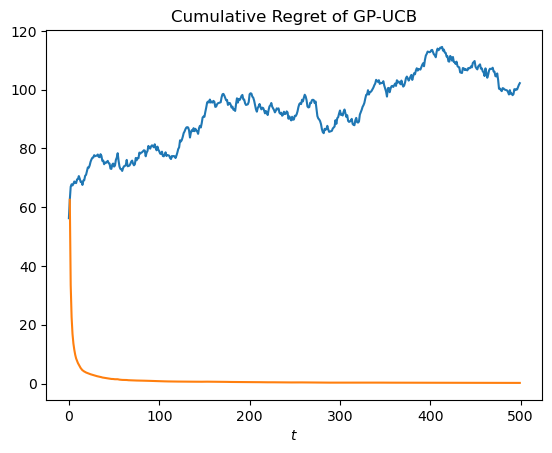

In [27]:
plt.figure()
plt.plot(cumulative_regret, label='Cumulative Regret')
times = range(T)
plt.plot(cumulative_regret/times, label='Cumulative Regret over time')
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

In [28]:
print(f'Theoretical bound: {np.sqrt(T)*n_customers}')
print(f'Actual Total Regret {(sum(expected_clairvoyant_rewards)-sum(agent_rewards))}')

Theoretical bound: 2236.06797749979
Actual Total Regret 102.19125599430117
